In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu, spearmanr
import numpy as np

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

# Alpha diversity analysis

##### Michael Shaffer
##### 7/20/22
##### Merck ESC, Sys bio group

Analysis of the alpha diversity of nasal samples sequenced with 16S sequencing.

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/nasal/nasal_metadata.csv', index_col='SampleID')
meta['age_at_collection'] = (pd.to_datetime(meta['CollectionDate']) - pd.to_datetime(meta['DOB'])).dt.days
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/nasal/nasal_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/nasal/nasal_titers_yr1.csv', index_col='SampleID')],
                 axis=1)
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
103_V5_NS_A1,Primary in Tube,1,NaN,NaN,NaN,"Box 1, A1",Nasal Swab,Human Infant,16S,103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106_V5_NS_A1,Primary in Tube,2,NaN,NaN,NaN,"Box 1, A3",Nasal Swab,Human Infant,16S,106,...,0.061955,0.052874,2.1,3.0,2.600000,0.3125,0.3125,1.375,1.140388,NVR
107_V2_NS_A1,Primary in Tube,3,NaN,NaN,NaN,"Box 1, A4",Nasal Swab,Human Infant,16S,107,...,0.958142,0.114018,4.4,5.2,10.666667,0.3125,1.1250,0.375,1.783418,NVR
107_V3_NS_A1,Primary in Tube,4,NaN,107_V8_NS_A1,NaN,"Box 1, A5",Nasal Swab,Human Infant,16S,107,...,0.958142,0.114018,4.4,5.2,10.666667,0.3125,1.1250,0.375,1.783418,NVR
107_V5_NS_A1,Primary in Tube,5,NaN,NaN,NaN,"Box 1, A8",Nasal Swab,Human Infant,16S,107,...,0.958142,0.114018,4.4,5.2,10.666667,0.3125,1.1250,0.375,1.783418,NVR


In [3]:
diversity = pd.read_csv('../../data/nasal/otu_alpha_diversity.csv', index_col=0)
diversity.head()

,shannon_div,simpson_e_div,n_otus_div
SampleID,,,
101_S1_NS_A1,1.620421,0.059385,40
101_V3_NS_A1,0.117681,0.073229,14
101_V5_NS_A1,2.678040,0.138003,32
102_V1_NS_A1,2.585534,0.090256,41
102_V3_NS_A1,2.093842,0.057135,43


In [4]:
in_both = set(meta.index) & set(diversity.index)
meta = pd.concat((meta.loc[in_both], diversity.loc[in_both]), axis=1)
meta.head()

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_6520/404026068.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta = pd.concat((meta.loc[in_both], diversity.loc[in_both]), axis=1)
/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_6520/404026068.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta = pd.concat((meta.loc[in_both], diversity.loc[in_both]), axis=1)


,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,...,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2,shannon_div,simpson_e_div,n_otus_div
SampleID,,,,,,,,,,,,,,,,,,,,,
214_S3_NS_A1,Primary in Tube,696,NaN,NaN,NaN,Box6_F6,Nasal Swab,Human Infant,16S,214,...,6.6,31.333333,1.5000,2.3750,3.625,4.422100,HVR,0.195443,0.049647,21
219_A1_NS_A1,Primary in Tube,235,NaN,NaN,NaN,"Box 5, C9",Nasal Swab,Human Infant,16S,219,...,22.7,31.933333,NaN,6.3750,6.125,12.433951,HVR,0.765209,0.039014,34
245_V6_NS_A1,Primary in Tube,367,NaN,NaN,NaN,Box1_I6,Nasal Swab,Human Infant,16S,245,...,1.0,5.733333,0.3125,0.3125,1.250,0.942257,LVR,0.276821,0.042762,25
227_V10_NS_A1,Primary in Tube,728,NaN,NaN,NaN,Box7_A2,Nasal Swab,Human Infant,16S,227,...,1.4,8.733333,1.6250,1.5000,1.250,1.628129,NVR,0.705548,0.037758,34
121_V10_NS_A1,Primary in Tube,610,NaN,NaN,NaN,Box5_F1,Nasal Swab,Human Infant,16S,121,...,5.1,2.333333,0.3125,1.2500,1.625,1.530271,NVR,1.649781,0.027092,73


## Explore alpha diversity

We are using 3 diversity metrics. Shannon for an over all measure, number of OTUs for richness and Simpson's E for evenness.

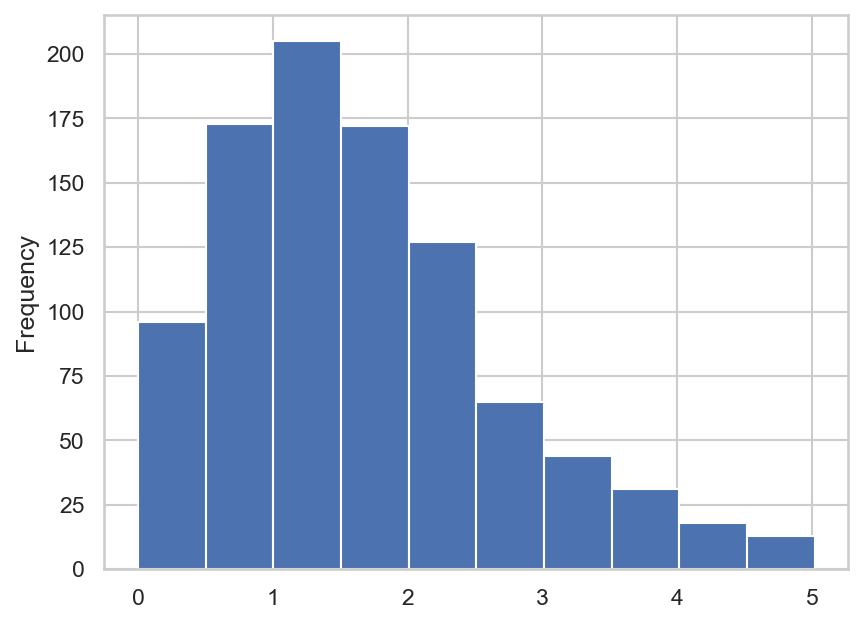

In [5]:
_ = meta['shannon_div'].plot(kind='hist')

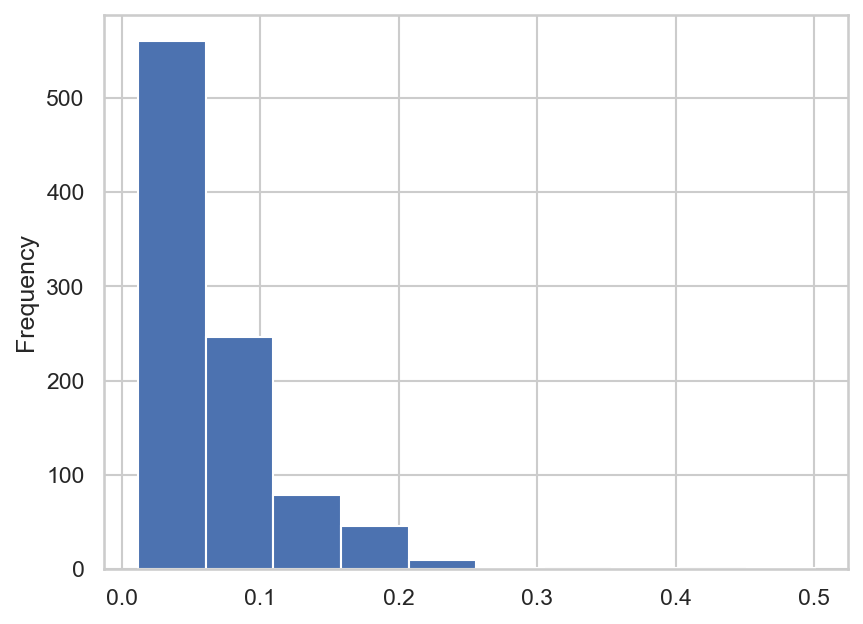

In [6]:
_ = meta['simpson_e_div'].plot(kind='hist')

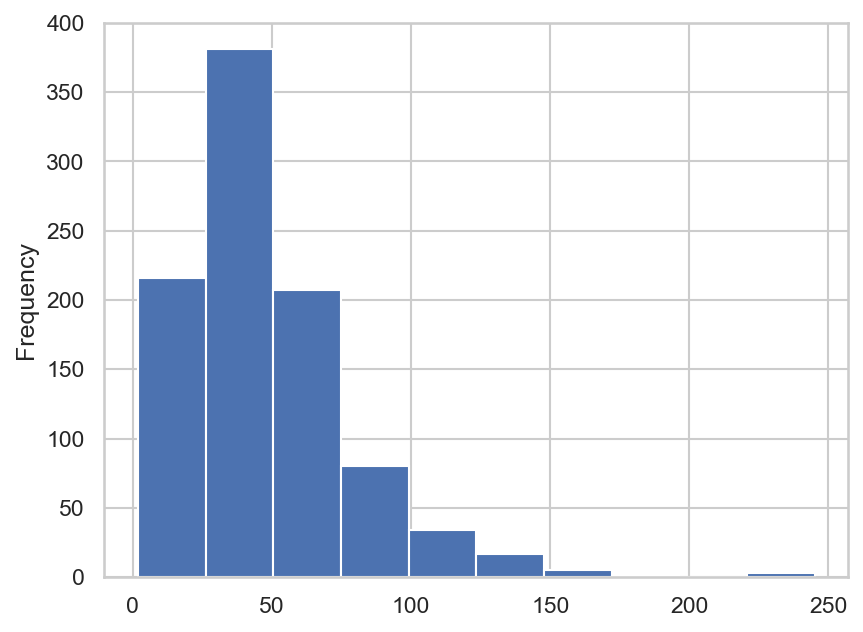

In [7]:
_ = meta['n_otus_div'].plot(kind='hist')

Pretty normal distribution of Shannon's diversity. Otherwise very right skewed.

## Shannon div

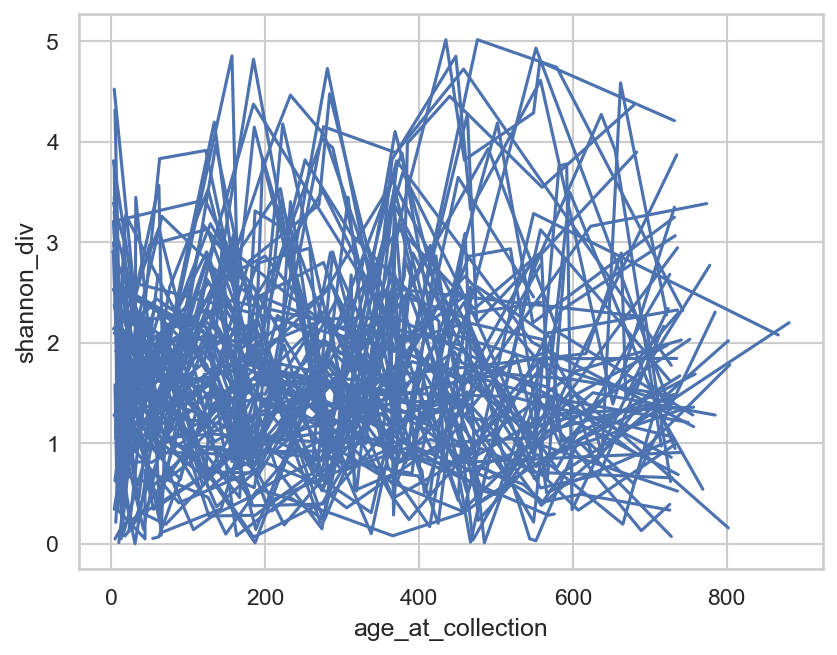

In [8]:
_ = sns.lineplot(x='age_at_collection', y='shannon_div', units='BabyN', estimator=None, markers=True, data=meta)

No clear trend over time.

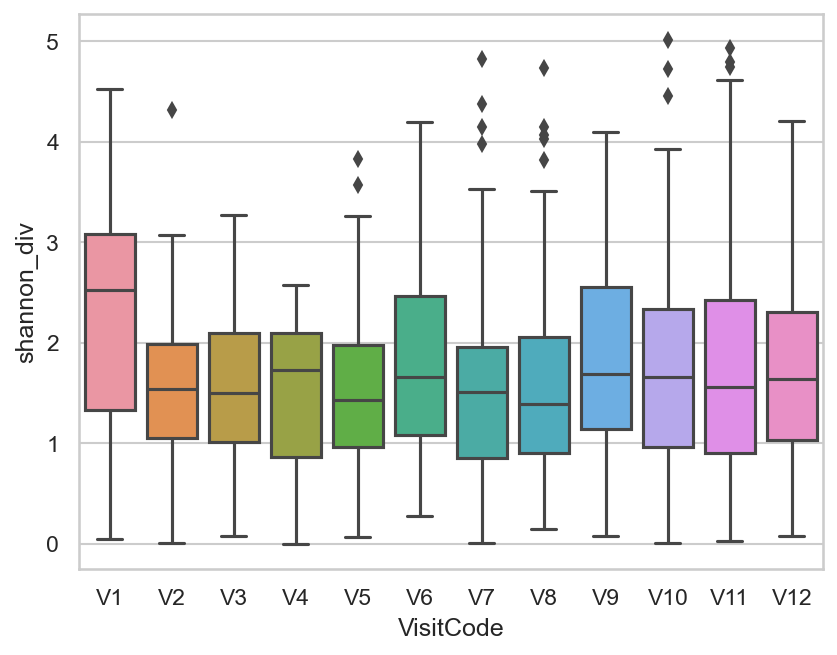

In [9]:
visit_codes = [i for i in meta['VisitCode'] if i.startswith('V')]
_ = sns.boxplot(x='VisitCode', y='shannon_div', data=meta.query("VisitCode in @visit_codes").sort_values('age_at_collection'))

When you look accross time points then you still cannot see an increase in diversity.

## Simpson E

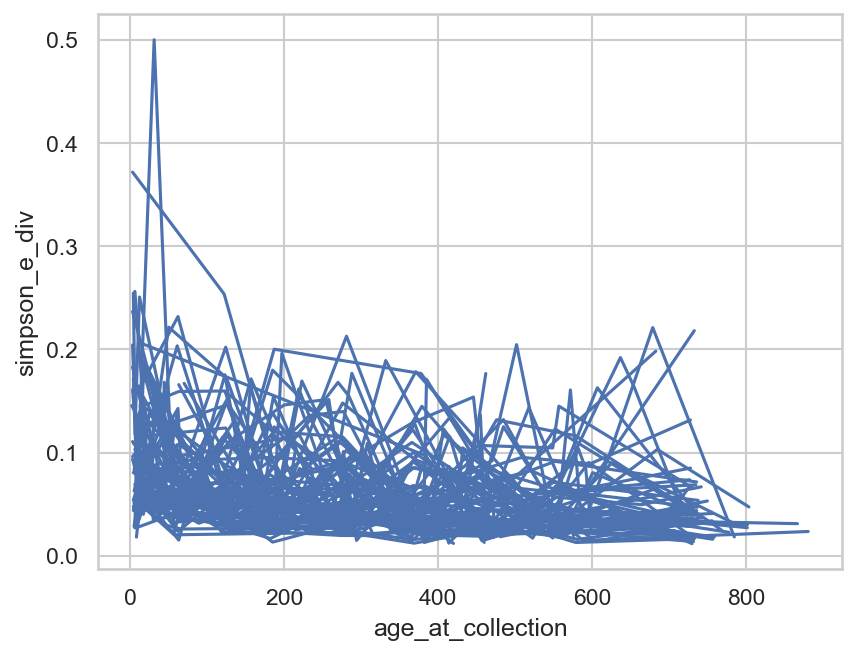

In [10]:
_ = sns.lineplot(x='age_at_collection', y='simpson_e_div', units='BabyN', estimator=None, markers=True, data=meta)

Maybe a decrease over time but mostly not a clear trend.

## # OTUs

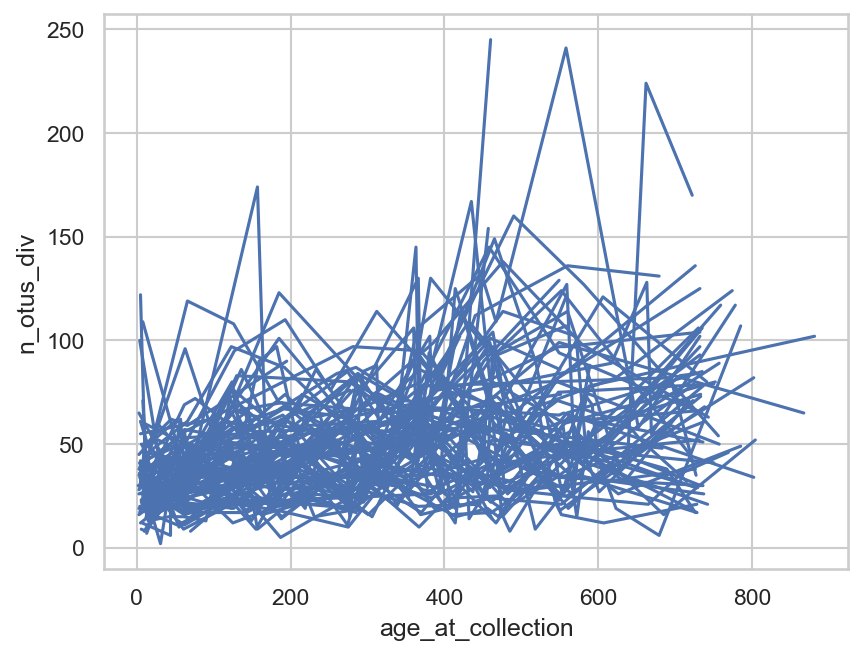

In [11]:
_ = sns.lineplot(x='age_at_collection', y='n_otus_div', units='BabyN', estimator=None, markers=True, data=meta)

Some increase in number of OTUs over time.

## Plotting both

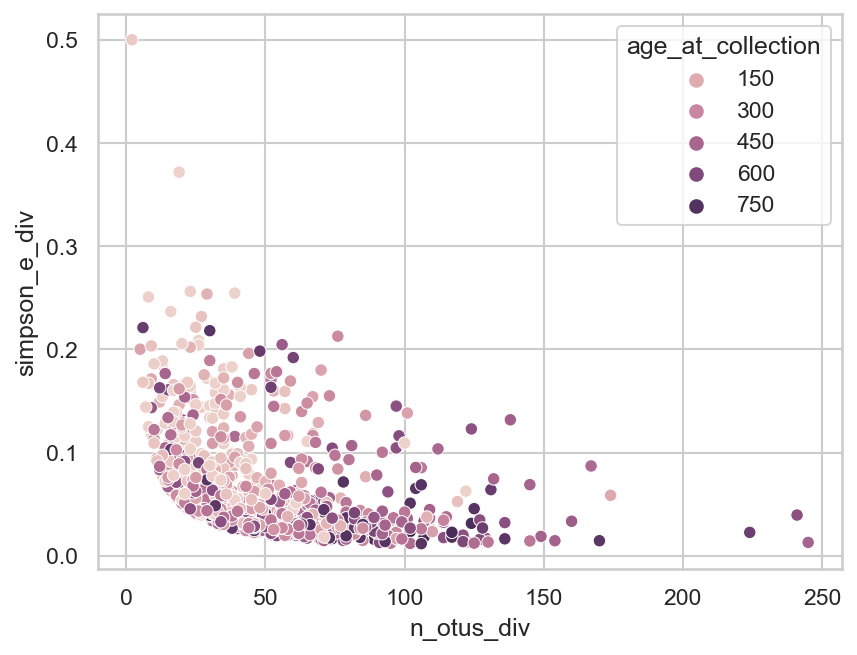

In [12]:
_ = sns.scatterplot(x='n_otus_div', y='simpson_e_div', hue='age_at_collection', data=meta)

Similar to the pattern with Kraken but not as strong. Definitely a enrichment of young points in the "cradle" of the plot. Generally an increase in age as we go to the righ and somewhat of a decrease in evenness.

## Color by Vaccine outcome

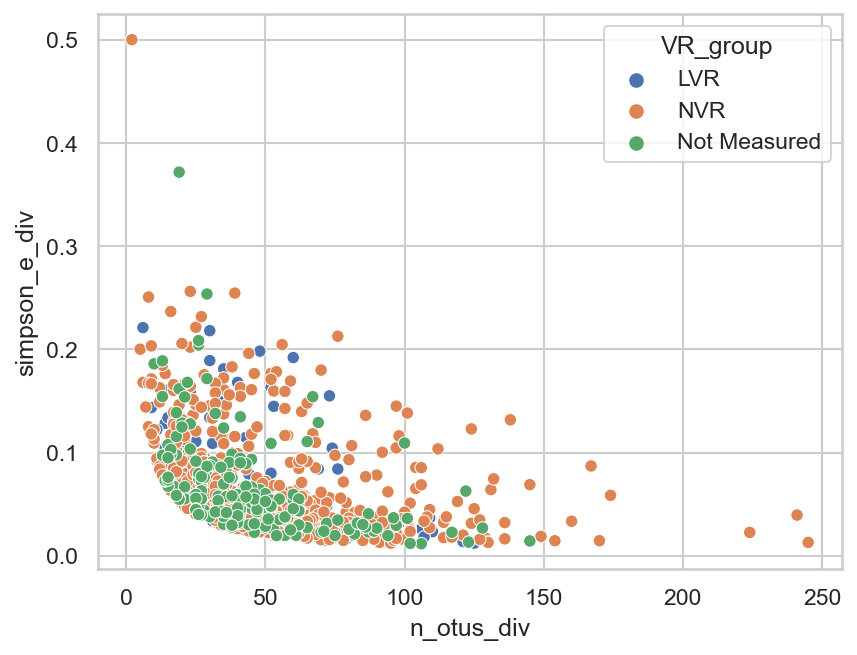

In [13]:
meta = meta.sort_values('VR_group')
_ = sns.scatterplot(x='n_otus_div', y='simpson_e_div', hue='VR_group', data=meta)

No pattern.

In [14]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
meta['2mo_sample'] = (meta['VisitCode'] == 'V5').astype(int)
meta['4mo_sample'] = meta['VisitCode'] == 'V6'
meta['6mo_sample'] = meta['VisitCode'] == 'V7'
meta['1yr_sample'] = meta['VisitCode'] == 'V9'

meta = meta.sort_values('VR_group')

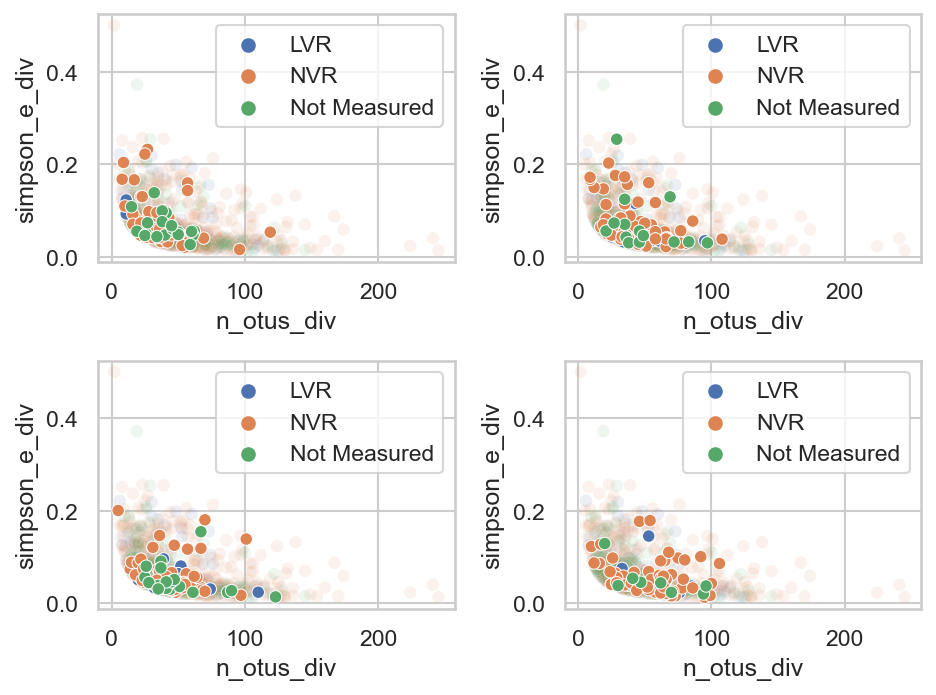

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta.loc[meta['2mo_sample'] == 0], alpha=0.1, ax=ax1)
ax1 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta[meta['2mo_sample'] == 1], alpha=1.0, ax=ax1)
legend_without_duplicate_labels(ax1)

ax2 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta.loc[meta['4mo_sample'] == 0], alpha=0.1, ax=ax2)
ax2 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta[meta['4mo_sample'] == 1], alpha=1.0, ax=ax2)
legend_without_duplicate_labels(ax2)

ax3 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta.loc[meta['6mo_sample'] == 0], alpha=0.1, ax=ax3)
ax3 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta[meta['6mo_sample'] == 1], alpha=1.0, ax=ax3)
legend_without_duplicate_labels(ax3)

ax4 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta.loc[meta['1yr_sample'] == 0], alpha=0.1, ax=ax4)
ax4 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='VR_group',
                     data=meta[meta['1yr_sample'] == 1], alpha=1.0, ax=ax4)
legend_without_duplicate_labels(ax4)

plt.tight_layout()

No pattern.

In [16]:
titer_assoc_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['n_otus_div', 'simpson_e_div', 'shannon_div']:
        N_LVR = len(meta.query("VisitCode == @timepoint & VR_group == 'LVR'"))
        N_NVR = len(meta.query("VisitCode == @timepoint & VR_group == 'NVR'"))
        if N_LVR > 2 and N_NVR > 2:
            w_value, p_value = mannwhitneyu(meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].values,
                                            meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].values)
            titer_assoc_rows.append([timepoint, div_metric, 'LVR/NVR', N_LVR, N_NVR, w_value, p_value])
titer_assocs = pd.DataFrame(titer_assoc_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'stat', 'p_value']).sort_values('p_value')
titer_assocs.head()

,timepoint,div_metric,titer_measure,N_LVR,N_NVR,stat,p_value
1,V1,simpson_e_div,LVR/NVR,3,18,9.0,0.079699
7,V6,simpson_e_div,LVR/NVR,11,52,206.0,0.150048
20,V5,shannon_div,LVR/NVR,8,57,156.0,0.156080
12,V11,n_otus_div,LVR/NVR,7,45,110.5,0.212403
29,V12,shannon_div,LVR/NVR,10,40,250.0,0.229925


### And continuous titer

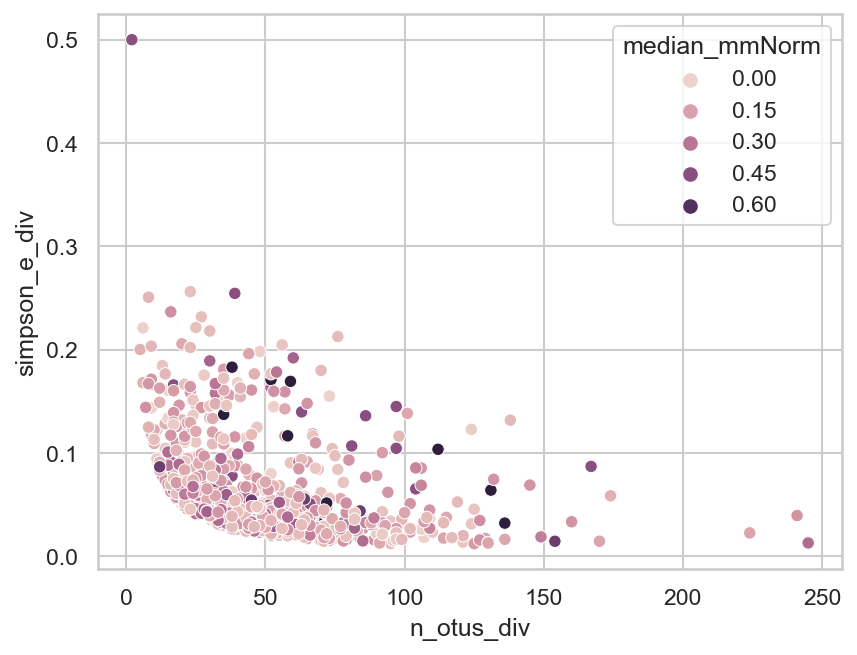

In [17]:
_ = sns.scatterplot(x='n_otus_div', y='simpson_e_div', hue='median_mmNorm', data=meta)

No pattern.

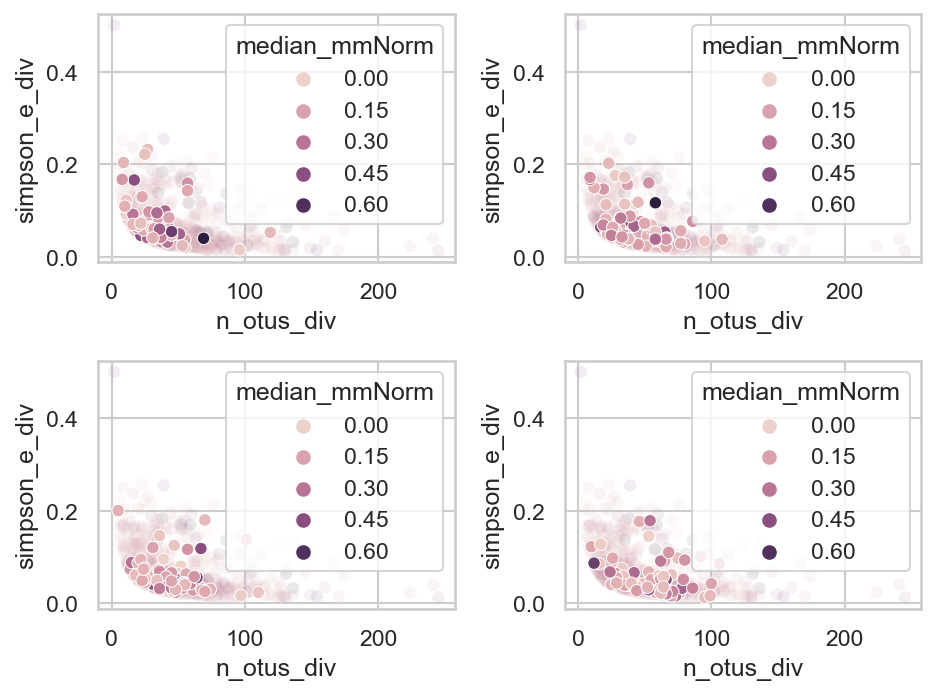

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta.loc[meta['2mo_sample'] == 0], alpha=0.1, ax=ax1, hue_norm=(0, meta['median_mmNorm'].max()))
ax1 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta[meta['2mo_sample'] == 1], alpha=1.0, ax=ax1, hue_norm=(0, meta['median_mmNorm'].max()), legend=False)
# legend_without_duplicate_labels(ax1)

ax2 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta.loc[meta['4mo_sample'] == 0], alpha=0.1, ax=ax2, hue_norm=(0, meta['median_mmNorm'].max()))
ax2 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta[meta['4mo_sample'] == 1], alpha=1.0, ax=ax2, hue_norm=(0, meta['median_mmNorm'].max()), legend=False)
# legend_without_duplicate_labels(ax2)

ax3 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta.loc[meta['6mo_sample'] == 0], alpha=0.1, ax=ax3, hue_norm=(0, meta['median_mmNorm'].max()))
ax3 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta[meta['6mo_sample'] == 1], alpha=1.0, ax=ax3, hue_norm=(0, meta['median_mmNorm'].max()), legend=False)
# legend_without_duplicate_labels(ax3)

ax4 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta.loc[meta['1yr_sample'] == 0], alpha=0.1, ax=ax4, hue_norm=(0, meta['median_mmNorm'].max()))
ax4 = sns.scatterplot(x="n_otus_div", y="simpson_e_div", hue='median_mmNorm',
                     data=meta[meta['1yr_sample'] == 1], alpha=1.0, ax=ax4, hue_norm=(0, meta['median_mmNorm'].max()), legend=False)
# legend_without_duplicate_labels(ax4)

plt.tight_layout()

No pattern.

### Correlations with titer

In [19]:
titer_correls_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['n_otus_div', 'simpson_e_div', 'shannon_div']:
        for titer_measure in ['median_mmNorm', 'median_mmNorm_DTAPHib', 'median_mmNorm_PCV']:
            N = len(meta.query("VisitCode == @timepoint")[titer_measure].dropna())
            if N > 3:
                r_value, p_value = spearmanr(meta.query("VisitCode == @timepoint")[div_metric].values,
                                             meta.query("VisitCode == @timepoint")[titer_measure].values,
                                             nan_policy='omit')
                titer_correls_rows.append([timepoint, div_metric, titer_measure, N, r_value, p_value])
titer_correls = pd.DataFrame(titer_correls_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N', 'R', 'p_value']).sort_values('p_value')
titer_correls.head()

,timepoint,div_metric,titer_measure,N,R,p_value
11,V10,n_otus_div,median_mmNorm_PCV,54,0.459858,0.000468
17,V10,shannon_div,median_mmNorm_PCV,54,0.385859,0.003956
9,V10,n_otus_div,median_mmNorm,57,0.372909,0.004278
4,V1,simpson_e_div,median_mmNorm_DTAPHib,21,0.459740,0.036008
101,V9,n_otus_div,median_mmNorm_PCV,63,0.234853,0.063916


In [20]:
titer_correls.query("p_value < .05")

,timepoint,div_metric,titer_measure,N,R,p_value
11,V10,n_otus_div,median_mmNorm_PCV,54,0.459858,0.000468
17,V10,shannon_div,median_mmNorm_PCV,54,0.385859,0.003956
9,V10,n_otus_div,median_mmNorm,57,0.372909,0.004278
4,V1,simpson_e_div,median_mmNorm_DTAPHib,21,0.459740,0.036008


In [21]:
col_order = ['body_site', 'timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'N', 'stat', 'R', 'p_value']
all_titer_stats = pd.concat([titer_assocs, titer_correls]).sort_values('p_value')
all_titer_stats['body_site'] = 'nasal'
all_titer_stats = all_titer_stats[col_order]
all_titer_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
11,nasal,V10,n_otus_div,median_mmNorm_PCV,NaN,NaN,54.0,NaN,0.459858,0.000468
17,nasal,V10,shannon_div,median_mmNorm_PCV,NaN,NaN,54.0,NaN,0.385859,0.003956
9,nasal,V10,n_otus_div,median_mmNorm,NaN,NaN,57.0,NaN,0.372909,0.004278
4,nasal,V1,simpson_e_div,median_mmNorm_DTAPHib,NaN,NaN,21.0,NaN,0.459740,0.036008
101,nasal,V9,n_otus_div,median_mmNorm_PCV,NaN,NaN,63.0,NaN,0.234853,0.063916


## Antibiotics

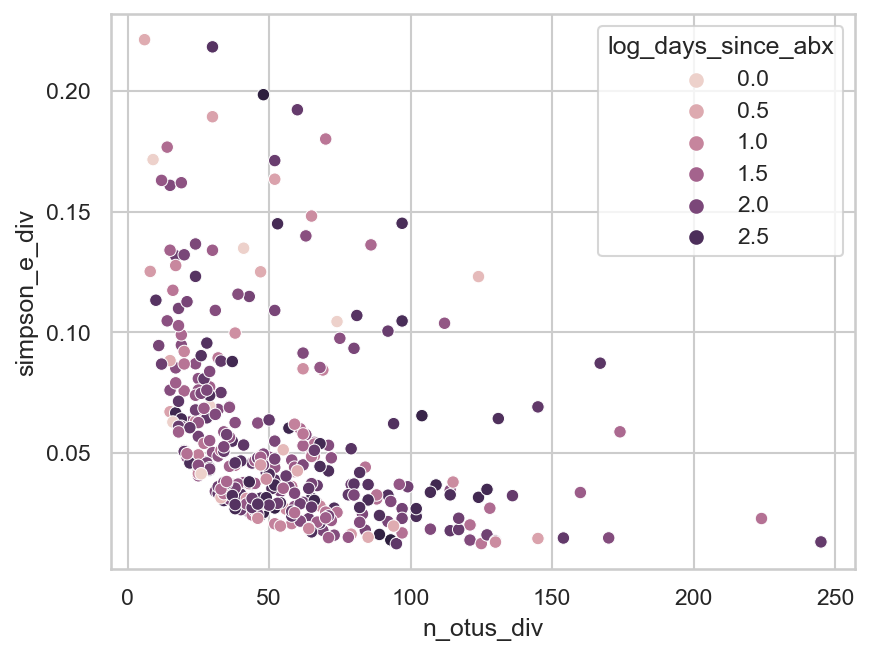

In [22]:
meta['log_days_since_abx'] = np.log10(meta['days_since_abx_end'])
_ = sns.scatterplot(x='n_otus_div', y='simpson_e_div', hue='log_days_since_abx', data=meta)

Want to see recent points up and to the left. No clear signal of this happening.

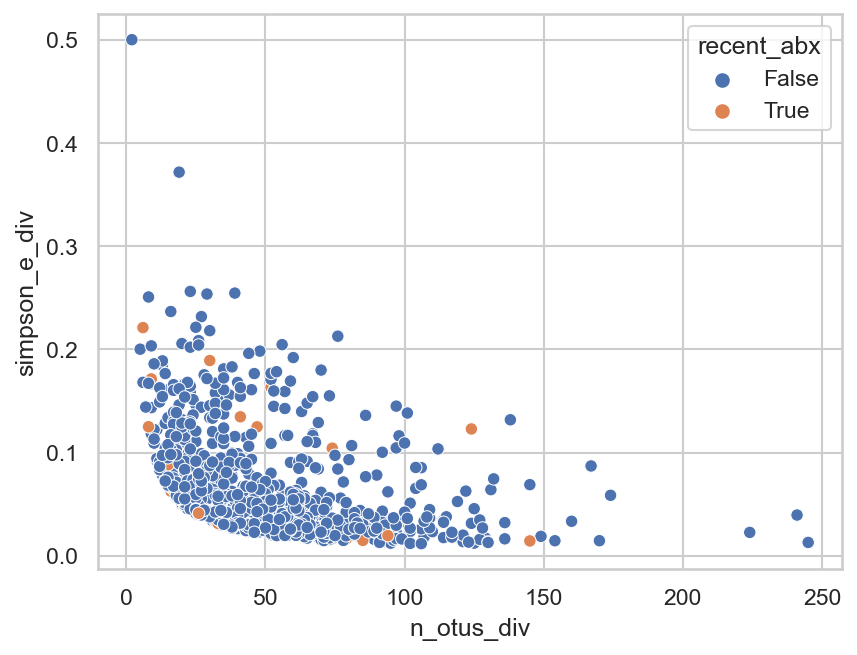

In [23]:
meta['recent_abx'] = meta['days_since_abx_end'] < 7
_ = sns.scatterplot(x='n_otus_div', y='simpson_e_div', hue='recent_abx', data=meta)

Want to see recent points up and to the left. No clear signal of this happening.